# LDA TOPIC MODELING 

This notebook applies LDA modeling to a dataset from a Kaggle dataset of news headlines:

https://www.kaggle.com/therohk/million-headlines

using GENSIM toolkit:

https://radimrehurek.com/gensim/

and following a really useful tutorial from machinelearningplus website:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/



__Steps__

- Text porcessing
- Bulding the model

__Other interesting links:__

- https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

- https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

- https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d

- https://stackoverflow.com/questions/20984841/topic-distribution-how-do-we-see-which-document-belong-to-which-topic-after-doi

- https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

__Required Libraries__

In [ ]:
import pandas as pd
import numpy as np


import string
import re
from pprint import pprint

# NLTK 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english') #this depends on each language

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

__Loading data__

In [65]:
df = pd.read_csv("listing_merged.csv", index_col = 0) 

In [66]:
df.shape[0]

72666

In [67]:
df.head(1)

,listing_id,title,description
0,663885606,St. Martin de Porres Dominican saint crochet a...,Handmade crochet doll of saint Martin de Porre...


In [78]:
data=df['title'].values.tolist()

In [79]:
pprint(data[:1])

['St. Martin de Porres Dominican saint crochet amigurumi kokeshi doll, '
 'catholic, kids gift, Easter basket stuffer, baby toy, nursery decor']


In [214]:
stop_words = stop_words.extend(['toy','not','etsy','www','item','make'])

In [81]:
# remove html
import html

def escape(texts): 
    return [html.unescape(str(text)) for text in texts]
def remove_html(texts):
    return [ re.sub(r"https?:\S+", "", str(text)) for text in texts]
data = escape(data)
data = remove_html(data)

__Tokenize words and Clean-up text__

In [82]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['st', 'martin', 'de', 'porres', 'dominican', 'saint', 'crochet', 'amigurumi', 'kokeshi', 'doll', 'catholic', 'kids', 'gift', 'easter', 'basket', 'stuffer', 'baby', 'toy', 'nursery', 'decor']]


__Bigrams & Trigrams__

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

In [83]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['st', 'martin', 'de', 'porres', 'dominican', 'saint', 'crochet', 'amigurumi', 'kokeshi', 'doll', 'catholic', 'kids', 'gift', 'easter', 'basket_stuffer', 'baby', 'toy', 'nursery', 'decor']


__Remove Stopwords, Make Bigrams and Lemmatize__

In [84]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

__Let’s call the functions in order__

In [85]:
#To run this code it is necessary to get the spacy moidel: "!python - m spacy download en", last depends on the used language 

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'es' model, keeping only tagger component (for efficiency)
# python3 -m spacy download es
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['martin', 'dominican', 'saint', 'crochet', 'amigurumi', 'kokeshi', 'doll', 'catholic', 'kid', 'gift', 'easter', 'basket', 'stuffer', 'baby', 'nursery', 'decor']]


__Create the Dictionary and Corpus needed for Topic Modeling__

In [86]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

id2word.filter_extremes(no_below=10, no_above=0.35)
id2word.compactify()

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]]


If you want to see what word a given id corresponds to, pass the id as a key to the dictionary

In [215]:
id2word[0]

'amigurumi'

Or, you can see a human-readable form of the corpus itself.

In [216]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('amigurumi', 1),
  ('baby', 1),
  ('basket', 1),
  ('catholic', 1),
  ('crochet', 1),
  ('decor', 1),
  ('doll', 1),
  ('dominican', 1),
  ('easter', 1),
  ('gift', 1),
  ('kid', 1),
  ('kokeshi', 1),
  ('martin', 1),
  ('nursery', 1),
  ('saint', 1),
  ('stuffer', 1)],
 [('baby', 1),
  ('kid', 1),
  ('accessory', 1),
  ('animal', 1),
  ('cute', 1),
  ('deer', 1),
  ('knit', 2),
  ('new', 1),
  ('newborn', 1),
  ('photo_shoot', 1),
  ('photography', 1),
  ('prop', 1),
  ('ready', 1),
  ('ship', 1),
  ('toy', 1),
  ('umigurumi', 1),
  ('year', 1)]]

In [217]:
from gensim.models import HdpModel
hdp = HdpModel(corpus, id2word, chunksize=10000)

In [218]:
len(hdp.print_topics())

20

In [219]:
hdp.print_topics(num_topics=20)

[(0,
  '0.003*baby + 0.003*block + 0.002*gift + 0.002*toy + 0.001*wooden + 0.001*doll + 0.001*play + 0.001*montessori + 0.001*board + 0.001*sensory'),
 (1,
  '0.002*baby + 0.002*book + 0.001*gift + 0.001*toddler + 0.001*busy + 0.001*sensory + 0.001*board + 0.001*wooden + 0.001*quiet + 0.001*montessori'),
 (2,
  '0.002*doll + 0.001*gift + 0.001*baby + 0.001*wooden + 0.001*child + 0.001*montessori + 0.001*block + 0.001*handmade + 0.001*vintage + 0.001*blue'),
 (3,
  '0.001*gift + 0.001*baby + 0.000*christmas + 0.000*wooden + 0.000*child + 0.000*creature + 0.000*misia + 0.000*find + 0.000*dondolino + 0.000*sarge'),
 (4,
  '0.004*baby + 0.003*gift + 0.003*block + 0.002*wooden + 0.001*personalize + 0.001*toy + 0.001*wood + 0.001*nursery + 0.001*kid + 0.001*montessori'),
 (5,
  '0.001*crayola + 0.001*tippee + 0.000*ancient + 0.000*moonbeam + 0.000*gift + 0.000*menthe + 0.000*tekno + 0.000*baby + 0.000*valse + 0.000*diesel'),
 (6,
  '0.001*baby + 0.000*block + 0.000*package + 0.000*gri + 0.00

__Building the Topic Model__

In [223]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


__View the topics in LDA model__

In [224]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.873*"baby" + 0.074*"birthday" + 0.019*"decoration" + 0.011*"party" + '
  '0.003*"dress" + 0.002*"count" + 0.001*"face" + 0.001*"costume" + '
  '0.001*"theater" + 0.000*"rattle"'),
 (1,
  '0.473*"wooden" + 0.109*"personalize" + 0.105*"puzzle" + 0.095*"name" + '
  '0.066*"alphabet" + 0.062*"letter" + 0.058*"board" + 0.012*"motor_skill" + '
  '0.004*"st" + 0.000*"building"'),
 (2,
  '0.608*"doll" + 0.045*"russian" + 0.016*"ussr" + 0.005*"sculpture" + '
  '0.000*"house" + 0.000*"paper" + 0.000*"printable" + 0.000*"dollhouse" + '
  '0.000*"soviet" + 0.000*"roly_poly"'),
 (3,
  '0.232*"shower" + 0.154*"girl" + 0.147*"custom" + 0.141*"boy" + '
  '0.096*"newborn" + 0.080*"inch" + 0.047*"blue" + 0.025*"green" + '
  '0.012*"free" + 0.010*"peg"'),
 (4,
  '0.752*"gift" + 0.074*"personalized" + 0.065*"baptism" + 0.039*"christmas" + '
  '0.016*"sign" + 0.013*"present" + 0.008*"customize" + 0.006*"cow" + '
  '0.000*"fluffy" + 0.000*"engrave"'),
 (5,
  '0.336*"travel" + 0.242*"car" + 0.056*"

In [228]:
corpus_test

[[(0, 1), (1, 1), (2, 1)]]

__Compute Model Perplexity and Coherence Score__

In [235]:
# example
#>>> other_texts = [ ['computer', 'time', 'graph'], ['survey', 'response', 'eps'], ['human', 'system', 'computer']]
# other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]
# unseen_doc = other_corpus[0]
# vector = lda[unseen_doc] 

test = [['toddler', 'busy' 'board', 'educational']]

id2word_test = corpora.Dictionary(test)

# Create Corpus

# Term Document Frequency
corpus_test = [id2word_test.doc2bow(text) for text in test]

#print(corpus_test[0])
topics = sorted(lda_model1[corpus_test],
                key=lambda 
                x:x[1],
                reverse=True)
for topic in topics:
    print(topic)
    print()

([(0, 0.031152688), (1, 0.06837297), (2, 0.040428303), (3, 0.23332876), (4, 0.12391052), (5, 0.05520159), (6, 0.0287262), (7, 0.1284429), (8, 0.13513303), (9, 0.04868399), (10, 0.06864475), (11, 0.037974276)], [(0, [8]), (1, [3]), (2, [4])], [(0, [(8, 0.9997792)]), (1, [(3, 0.99999803)]), (2, [(4, 0.99972886)])])



In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

__Visualize the topics-keywords__

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

__Building LDA Mallet Model__

The MALLET topic model package includes an extremely fast and highly scalable implementation of Gibbs sampling, efficient methods for document-topic hyperparameter optimization, and tools for inferring topics for new documents given trained models. 

In [92]:
import os
os.environ.update({'MALLET_HOME':r'C:/Work/Projects/Insight/data/LDA-Topic-Modeling-master/Python/mallet-2.0.8/'})
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'C:\\Work\\Projects\\Insight\\data\\LDA-Topic-Modeling-master\\Python\\mallet-2.0.8\\bin\mallet'#./mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [93]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('toy', 0.3281338550802861),
   ('wooden', 0.3102415328565646),
   ('car', 0.04463635136958575),
   ('wood', 0.04301713668870598),
   ('natural', 0.03748481986236675),
   ('montessori', 0.03616246120631494),
   ('eco_friendly', 0.03006341924166779),
   ('eco', 0.014330049925785994),
   ('waldorf', 0.011010659829982459),
   ('push', 0.006665767102955067)]),
 (4,
  [('blue', 0.06618336886993603),
   ('ball', 0.061236673773987206),
   ('pink', 0.049182658137882015),
   ('pillow', 0.04380952380952381),
   ('green', 0.034456289978678036),
   ('soft', 0.030987917555081734),
   ('yellow', 0.029566453447050462),
   ('fabric', 0.028429282160625444),
   ('owl', 0.02794598436389481),
   ('star', 0.026353944562899786)]),
 (5,
  [('puzzle', 0.2004714454087646),
   ('game', 0.16554162648666024),
   ('card', 0.033697632058287796),
   ('piece', 0.02911711132540448),
   ('learn', 0.021134683381549342),
   ('family', 0.019848923175827708),
   ('number', 0.018804243008678882),
   ('jigsaw', 0.01

__How to find the optimal number of topics for LDA?__

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [94]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [95]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [ ]:
model_list_1, coherence_values_1 = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=2)

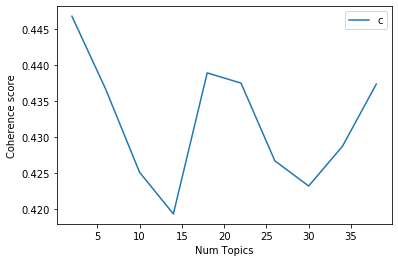

In [238]:
# Show graph
limit=40; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values_1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [239]:
# Print the coherence scores
for m, cv in zip(x, coherence_values_1):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4468
Num Topics = 6  has Coherence Value of 0.4367
Num Topics = 10  has Coherence Value of 0.4252
Num Topics = 14  has Coherence Value of 0.4194
Num Topics = 18  has Coherence Value of 0.439
Num Topics = 22  has Coherence Value of 0.4375
Num Topics = 26  has Coherence Value of 0.4267
Num Topics = 30  has Coherence Value of 0.4232
Num Topics = 34  has Coherence Value of 0.4288
Num Topics = 38  has Coherence Value of 0.4374


In [244]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(20,
  '0.271*"kid" + 0.110*"play" + 0.094*"teepee" + 0.069*"tent" + '
  '0.067*"children" + 0.048*"mat" + 0.033*"tipi" + 0.015*"playhouse" + '
  '0.012*"wigwam" + 0.009*"indian"'),
 (15,
  '0.205*"board" + 0.135*"sensory" + 0.105*"busy" + 0.101*"toddler" + '
  '0.097*"activity" + 0.052*"montessori" + 0.047*"travel" + 0.047*"cube" + '
  '0.031*"fine_motor" + 0.030*"skill"'),
 (26,
  '0.225*"vintage" + 0.165*"child" + 0.042*"barbie" + 0.037*"letter" + '
  '0.037*"alphabet" + 0.030*"collectible" + 0.019*"fish" + 0.019*"duck" + '
  '0.016*"mattel" + 0.015*"abc"'),
 (7,
  '0.106*"blue" + 0.093*"white" + 0.070*"red" + 0.067*"dog" + 0.066*"elephant" '
  '+ 0.055*"green" + 0.048*"black" + 0.046*"yellow" + 0.034*"grey" + '
  '0.031*"pink"'),
 (1,
  '0.077*"small" + 0.066*"peg" + 0.052*"child" + 0.046*"large" + 0.029*"mini" '
  '+ 0.025*"family" + 0.020*"table" + 0.020*"world" + 0.020*"friend" + '
  '0.018*"people"'),
 (23,
  '0.129*"hand" + 0.083*"puppet" + 0.064*"child" + 0.045*"paint" + '
 

__Finding the dominant topic in each sentence__

In [245]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        print(row)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            print(j, " ", topic_num, " ", prop_topic)
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus_test, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(30)

[(1, 0.04834905660377362), (17, 0.04834905660377362), (9, 0.04205974842767298), (5, 0.033674004192872135), (8, 0.03157756813417193), (0, 0.02948113207547172), (2, 0.02948113207547172), (3, 0.02948113207547172), (4, 0.02948113207547172), (6, 0.02948113207547172), (7, 0.02948113207547172), (10, 0.02948113207547172), (11, 0.02948113207547172), (12, 0.02948113207547172), (13, 0.02948113207547172), (14, 0.02948113207547172), (15, 0.02948113207547172), (16, 0.02948113207547172), (18, 0.02948113207547172), (19, 0.02948113207547172), (20, 0.02948113207547172), (21, 0.02948113207547172), (22, 0.02948113207547172), (23, 0.02948113207547172), (24, 0.02948113207547172), (25, 0.02948113207547172), (26, 0.02948113207547172), (27, 0.02948113207547172), (28, 0.02948113207547172), (29, 0.02948113207547172), (30, 0.02948113207547172), (31, 0.02948113207547172)]
0   1   0.04834905660377362
1   17   0.04834905660377362


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.0483,"small, peg, child, large, mini, family, table, world, friend, people","St. Martin de Porres Dominican saint crochet amigurumi kokeshi doll, catholic, kids gift, Easter basket stuffer, baby toy, nursery decor"
1,1,NaN,NaN,NaN,Knitted kids Toy Umigurumi Deer - Knit baby toys - Cute animals- new year- Photo shoot props- Newborn photography accessories- READY TO SHIP
2,2,NaN,NaN,NaN,Knitted newborn Toy gray rabbit - Knit baby bunny toys - Photo shoot props - Newborn photography accessories - Boy - Girl - READY TO SHIP
3,3,NaN,NaN,NaN,Bat Crochet Bat Halloween bat Amigurumi plush bat vampire bat creepy monster Stuffed animals Handmade toy adult gift halloween decoration
4,4,NaN,NaN,NaN,"Crocheted Stroller Necklace, crochet maxi cosi pendant, baby gym, wood-gripping, heart, wooden beads, beautiful and homemade, baby gym"
5,5,NaN,NaN,NaN,"Enchanted Forest Board Game 1994, Vintage Board Game, Children's Board Game,Vintage Children's Board Game, :)s***"
6,6,NaN,NaN,NaN,"Vintage Preschool Rainbow Works Puzzles Little Rabbits and Insects, Vintage Childs Puzzle, Babies Nursery Decor, Childs Room Decor, :)s*"
7,7,NaN,NaN,NaN,Handmade Knit Jellyfish Plushie
8,8,NaN,NaN,NaN,Colonial American history book for children of the Boston Tea Party. 1982 paperback with great pencil sketch illustrations.
9,9,NaN,NaN,NaN,FALL SUBSCRIPTION BOX


In [ ]:
df_dominant_topic.shape

In [119]:
pd.set_option('display.max_colwidth', -1)

__Find the most representative document for each topic__

In [188]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(15)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3153,"doll, handmade, girl, dress, inch, clothe, cloth, fabric, rag, cm",Tilda Textile Art dolls only Interior doll Girl textile doll Textile girl doll Cloth doll Soft dolls Rag doll Tilda doll Gift Fabric doll
1,1.0,0.2965,"vintage, puzzle, cat, child, piece, miniature, plastic, dollhouse, collection, original","Disney Mickey Mouse and Minnie mouse puzzle, Jaymar puzzle,Mickey Mouse tray puzzle, Disney Puzzle, Mickey Puzzle, Vintage Disney puzzle"
2,2.0,0.3320,"kid, child, decor, nursery, teepee, tent, children, room, mat, house","Teepee Tent For Kids, Teepee, Childrens Teepee, Kids Tent, Tipi, Kids Teepee, Teepee Tent, Teepee Tent Kids, Wigwam, Play Tent, Teepee Kids"
3,3.0,0.3156,"wooden, toy, block, wood, natural, eco_friendly, alphabet, mouse, letter, building",Wooden Alphabet Blocks | Alphabet Blocks | Toy Wood Blocks| ABC Blocks| Alphabet Blocks| Wood Blocks| Wood Alphabet Blocks| Wooden Blocks
4,4.0,0.2976,"gift, birthday, personalize, boy, girl, christmas, custom, personalized, personalise, birth","Gift for twins, newborn twins gift, twins gift idea, personalized twins gift, triplets gift, baby twins gift, custom twins toys, twin girls"
5,5.0,0.2869,"pink, blue, white, red, pillow, green, cotton, black, yellow, size",Pocket pillow owl embroidery navy satin reading pillow childs reading pillow navy orange aqua fleece orange zip close white quilted pocket
6,6.0,0.2857,"montessori, waldorf, educational, learn, rainbow, color, peg, inspire, preschool, learning",Oak Tree Swing Oak Swing Stained Oak Swing Rope Swing Tree Swing Wood Tree Swing Yard Swing Stained Wood Swing Swing Yard Swing
7,7.0,0.3366,"play, set, feel, food, pretend, kitchen, tea, accessory, vegetable, fruit","Felt Food Donut Set, Pretend Food, Pretend Play, Play Food, Felt Food Set, Children's Gifts, Play Kitchen, Felt Food, Donut Felt Food Set,"
8,8.0,0.2772,"game, child, car, animal, dog, mask, card, horse, halloween, family",Yoga Memory Game/ Yoga Game / Yoga Memory Game / Karomi Yoga / Kids Yoga / Memo Game/ Yoga Game for Kids
9,9.0,0.3457,"book, toddler, board, sensory, busy, activity, quiet, montessori, travel, feel",Quiet book Quiet book for toddlers Toddler quiet book Quiet book page Felt busy book Felt quiet book Quiet book pages Toddler felt book


__Topic distribution across documents__

In [187]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"kid, child, decor, nursery, teepee, tent, children, room, mat, house",6321.0,0.0870
1.0,12.0,"crochet, animal, stuff, bear, plush, soft, amigurumi, bunny, knit, handmade",7604.0,0.1046
2.0,12.0,"crochet, animal, stuff, bear, plush, soft, amigurumi, bunny, knit, handmade",3679.0,0.0506
3.0,8.0,"game, child, car, animal, dog, mask, card, horse, halloween, family",5207.0,0.0717
4.0,11.0,"baby, rattle, shower, teether, teething, ring, organic, wood, gym, newborn",3620.0,0.0498
5.0,8.0,"game, child, car, animal, dog, mask, card, horse, halloween, family",5132.0,0.0706
6.0,2.0,"kid, child, decor, nursery, teepee, tent, children, room, mat, house",4585.0,0.0631
7.0,12.0,"crochet, animal, stuff, bear, plush, soft, amigurumi, bunny, knit, handmade",4641.0,0.0639
8.0,8.0,"game, child, car, animal, dog, mask, card, horse, halloween, family",5121.0,0.0705
9.0,7.0,"play, set, feel, food, pretend, kitchen, tea, accessory, vegetable, fruit",5205.0,0.0716
